# 0.0.Entendimento do projeto

**Objetivo do projeto, como ele sera resolvido e muitas outras informações contidas no arquivo PDS(Plano de Solução).**


**OBS:** Como realizei diversas análises e cálculos no notebook anterior e salvei os dados balanceados, decidir apenas deixar esse notebook com o enconder dos dados e assim por diante nos modelos de ML, será mais rápido e mais logico trabalhar assim.

# 1.0.Impots

In [1]:
#Manipulação de dados
import pandas as pd
import numpy as np
import sys , os

#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

#SQl
import sqlalchemy

#Machine Learning Models
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler

#Rebalanceamento de dados
from imblearn import combine as c

# Estatística
import scipy
from scipy.stats import normaltest
from scipy.stats import chi2_contingency


#filterwarnings
import warnings
warnings.filterwarnings('ignore')

#Show all columns
pd.set_option('display.max_columns', None)

## 1.1.Funções de ajuda

In [17]:
sys.path.append(os.path.abspath(os.path.join('modulos')))

#Funções Gerais
from functions_help import data_dimensions,analise_descritiva_dos_dados

#Validação
from cross_validation import cross_validation_kfold_class

from visualization import sns_histplot


#Avaliar perfomance
from models_performance import model_perfomance_class

#Feature Selection
from feature_selection import selecao_univariada,eliminacao_recursiva_rfe, relevancia_iv

# 2.0.Enconder dos dados

In [3]:
df2 = pd.read_feather('datasets/dados_balanceados.feather')
df2.head()

,credit_score,Tenure,Balance,num_of_products,isActiveMember,estimated_salary,geography,gender,age_cat,exited
0,612.0,1.0,0.00,1.0,1.0,83256.26,Spain,Male,29-38,1
1,601.0,1.0,64430.06,2.0,1.0,96517.97,France,Male,39-48,0
2,627.0,6.0,57809.32,1.0,0.0,188258.49,Germany,Female,29-38,0
3,745.0,10.0,96048.55,1.0,0.0,74510.65,Germany,Male,39-48,0
4,532.0,9.0,0.00,2.0,0.0,30583.95,France,Male,29-38,0


In [4]:
#Separando os dados entre numéricos e categoricos, pois será necessario para realizar as transformações

attributes_num = df2.select_dtypes(include=['int64','float64']).drop('exited',axis=1)
attibutes_cat  = df2.select_dtypes(include=['object'])

col_num = attributes_num.columns.tolist()
col_cat = attibutes_cat.columns.tolist()

## 2.1.Fazendo Rescaling nos dados

**Rescaling escolhido: RobustScaler**

**Motivo:** Acredito que ele e o melhor, pois foi feito para lidar com grandes distribuições de dados, pegando os valores de quartil para realizar seus cálculos, assim sendo pouco influenciado para valor outliers nos dados.

In [5]:
rs = RobustScaler()

In [6]:
df2[col_num] = rs.fit_transform(df2[col_num].values)
df2.head(3)

,credit_score,Tenure,Balance,num_of_products,isActiveMember,estimated_salary,geography,gender,age_cat,exited
0,-0.304518,-1.00,-0.798963,0.0,0.720705,-0.181422,Spain,Male,29-38,1
1,-0.390407,-1.00,-0.298145,1.0,0.720705,-0.045743,France,Male,39-48,0
2,-0.187396,0.25,-0.349608,0.0,-0.279295,0.892843,Germany,Female,29-38,0


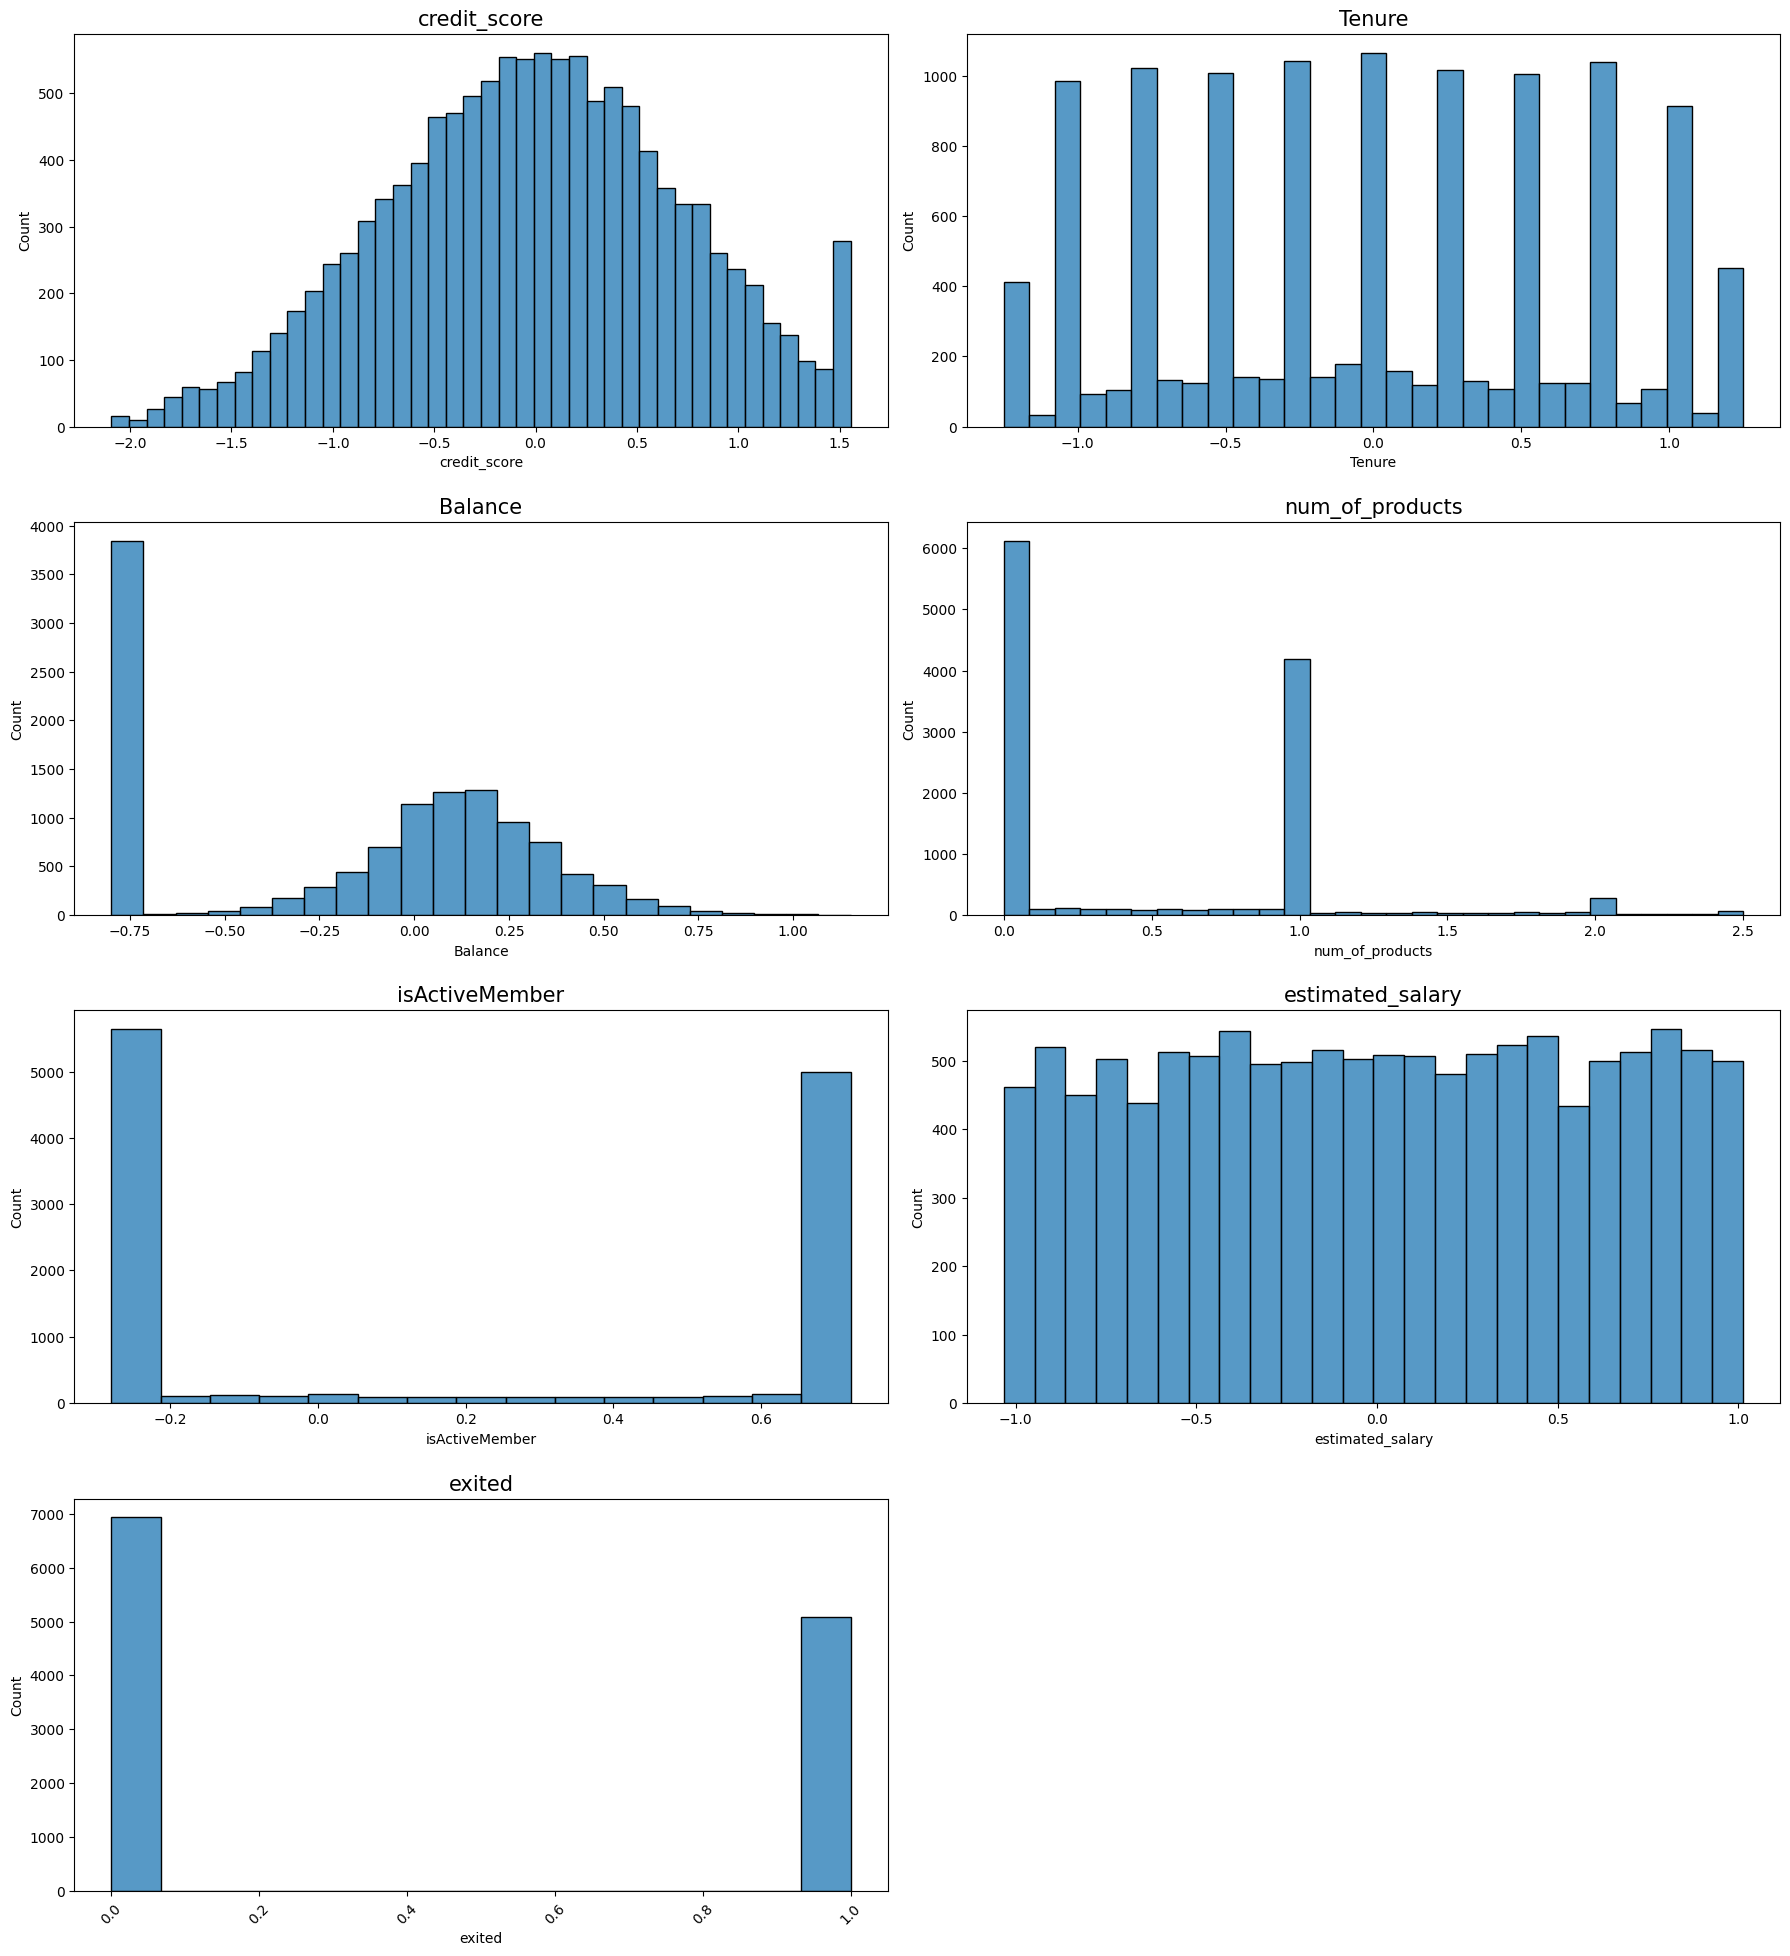

In [7]:
#Analisando a distribuição dos dados reescalados
sns_histplot(df2,df2.select_dtypes(include=['int64','float64']).columns.tolist())

## 2.2.Tratando as features categoricas.

**Metodo usado: Relevancia WOE**

**Motivo:** Usarei a relevância da predição da feature para substituir o valor dela, farei por que julgo ser o mais apropriado para os nossos dados, embora o One Hot não seja má ideia, acredito que a força preditora da variável pode me surpreender e me dar bons resultados. 

<Figure size 700x700 with 0 Axes>

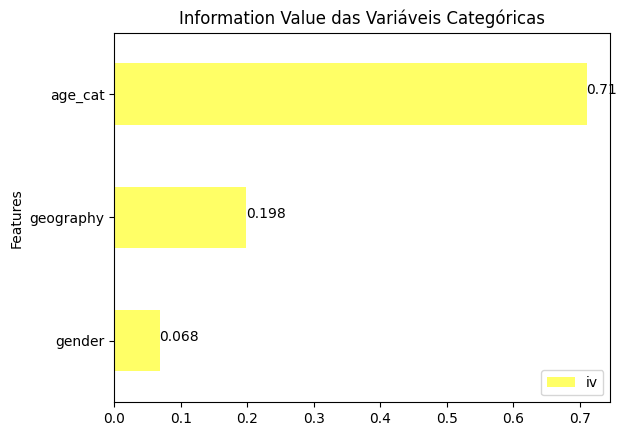

In [8]:
results = relevancia_iv(df2,col_cat,'exited')

In [9]:
#Relevancia de cada valor
results.reset_index().rename(columns={'index':'Feature'})[['Feature','woe']]

exited,Feature,woe
0,France,-0.305765
1,Germany,0.672271
2,Spain,-0.285178
3,Female,0.268062
4,Male,-0.256816
5,18-28,-1.186965
6,29-38,-0.852067
7,39-48,0.401472
8,49+,1.209181


In [10]:
df2['geography'] = df2['geography'].apply(lambda x: np.round(-0.30576518233901606,4) if x == 'France' else
                                 np.round(0.6722712456759936,4) if x == 'Germany' else np.round(0.-0.28517824850850665,4) )

df2['gender'] = df2['gender'].apply(lambda x: np.round(-0.2568164644490587,3) if x == 'Male' else np.round(0.26806228125338905,4))


df2['age_cat'] = df2['age_cat'].apply(lambda x: np.round(-1.1869652746964552,4) if x == '18-28' else
                                                 np.round(-0.8520671946724286,4) if x == '29-38' else
                                                 np.round(0.40147162830539146,4) if x == '39-48' else np.round(1.209180769346363,4))

# 3.0.Seleção de colunas


In [11]:
X = df2.drop('exited',axis=1)
y = df2['exited']

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [13]:
X_train[:10]

,credit_score,Tenure,Balance,num_of_products,isActiveMember,estimated_salary,geography,gender,age_cat
7363,-1.686560,-0.750000,-0.355767,1.000000,0.720705,-0.972771,0.6723,-0.2570,-0.8521
8027,0.874513,1.000000,-0.798963,0.000000,0.720705,-0.712234,-0.3058,-0.2570,-0.8521
6187,1.553821,-0.250000,-0.037278,1.000000,-0.279295,0.058336,0.6723,0.2681,0.4015
11614,-0.789708,1.008299,0.319000,0.966804,-0.279295,0.413768,0.6723,0.2681,0.4015
10332,0.557503,0.516678,0.158809,2.000000,0.720705,0.294330,-0.2852,0.2681,1.2092
2110,-0.210820,1.250000,-0.798963,1.000000,0.720705,0.871582,-0.2852,0.2681,-0.8521
8862,-0.342375,0.875172,-0.175866,0.000000,-0.279295,-0.833156,-0.3058,0.2681,0.4015
2375,0.679309,1.000000,0.282317,0.000000,-0.279295,0.418269,0.6723,0.2681,-0.8521
9148,-0.528620,0.128190,0.139439,0.000000,-0.279295,-0.363834,0.6723,-0.2570,1.2092
10775,0.432887,0.865204,-0.003544,0.000000,-0.279295,0.787770,0.6723,0.2681,-0.8521


# 4.0.Machine Learning Models

In [14]:
lc = LogisticRegression(C=0.01)
lc.fit(X_train,y_train)

LogisticRegression(C=0.01)

# 5.0.Models Perfomance

## 5.1.Simple Performance

Previsões erradas sobre o Total
1002 / 3605


Accuracy: 72.21%
Balacend Acurracy: 70.85%
Kappa Score: 42.26%
AUC: 0.7085

               precision    recall  f1-score   support

           0       0.74      0.79      0.77      2085
           1       0.69      0.62      0.65      1520

    accuracy                           0.72      3605
   macro avg       0.72      0.71      0.71      3605
weighted avg       0.72      0.72      0.72      3605



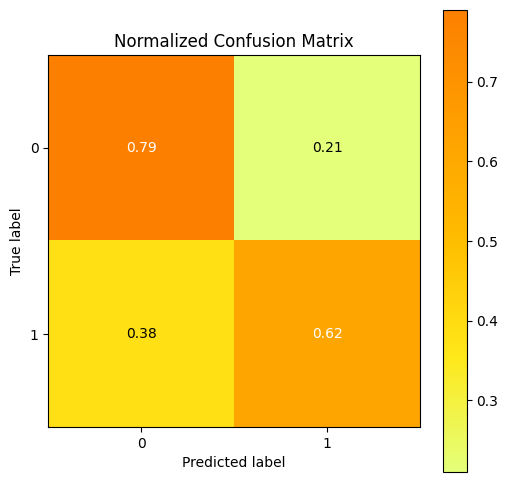

In [19]:
results_lc = lc.predict(X_test)
model_perfomance_class(y_test,results_lc)

## 5.2.Cross Validation Performance


In [16]:
lc_cv = LogisticRegression(C=0.01)
cross_validation_kfold_class('LogisticRegression',lc_cv,10,X_train,y_train,verbose=True)

Folds: 1/10
Folds: 2/10
Folds: 3/10
Folds: 4/10
Folds: 5/10
Folds: 6/10
Folds: 7/10
Folds: 8/10
Folds: 9/10
Folds: 10/10


,Model Name,acurracy_score,Balacend_Acurracy,Kappa_Score,AUC
0,LogisticRegression,72.00%+/- 1.00%,71.00%+/- 1.00%,43.00%+/- 0.00%,71.00%+/- 1.00%


**O que foi feito nessa etapa?**
- Enconder dos dados:
    - Essa é uma etapa importante para os modelos de Machine Learnings, pois eles não aceitam valores categóricos e a maioria não performa bem com valores em escalas diferentes, por isso e bom modificar o valor categórico e reescalar os dados, e foi isso que fiz nesse passo do projeto.
    
**O que será feito na próxima etapa?**
- Seleção de colunas:
    - Usarei alguma/algumas das minhas funções de seleção de coluna, pois embora não tenhamos dados muito dimensionados, acredito que tem certas feature que são mais relevantes que outras e isso e bom para a empresa saber.

**Próxima etapa:**
Seleção de colunas